In [159]:
import os
import random
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

from libs.utils import *
from libs.generate_boxes import *

In [160]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
tf.get_logger().setLevel('INFO')
tf.keras.backend.floatx()

'float32'

In [161]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

In [185]:
class A2CAgent:
    def __init__(self, state_size, action_size):
        self.render = False
        self.load_model = False

        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1

        self.discount_factor = 0.99
        self.actor_lr = 0.001
        self.critic_lr = 0.005

        self.actor = self.build_actor()
        self.critic = self.build_critic()

    def build_actor(self):
        actor = Sequential(name = 'actor')
        actor.add(Dense(24, input_dim=self.state_size, activation='relu'))
        if self.action_size == 1:
            actor.add(Dense(self.action_size, activation='linear'))
        else:
            actor.add(Dense(self.action_size, activation='softmax'))
        actor.summary()
        actor.compile(loss='categorical_corssentropy', optimizer=Adam(lr=self.actor_lr))
        return actor

    def build_critic(self):
        critic = Sequential(name = 'critic')
        critic.add(Dense(24, input_dim=self.state_size, activation='relu'))
        critic.add(Dense(self.value_size, activation='linear'))
        critic.summary()
        critic.compile(loss='mse', optimizer=Adam(lr=self.critic_lr))
        return critic

    def get_action(self, state, action_ops):
        state = np.array([state.flatten()] * len(action_ops))
        actions = np.array([sample.flatten() for sample in action_ops])
        print(state.shape, actions.shape)
        print(state, actions)
        print(np.concatenate([state, actions], axis=1).shape)
        print(np.concatenate([state, actions], axis=1))
        policy = self.actor.predict(state, batch_size=1).flatten()
        print(policy)
        return np.random.choice(self.action_size, 1, p=policy)[0]

    def train_model(self, state, action, reward, next_state, done):
        target = np.zeros((1, self.value_size))
        advantages = np.zeros((1, self.action_size))

        value = self.critic.predict(state)[0]
        next_value = self.critic.predict(next_state)[0]

        if done:
            advantages[0][action] = reward - value
            target[0][0] = reward
        else:
            advantages[0][action] = reward + self.discount_factor * (next_value) - value
            target[0][0] = reward + self.discount_factor * next_value

        self.actor_history = self.actor.fit(state, advantages, epochs=1, verbose=0)
        self.critic_history = self.critic.fit(state, target, epohcs=1, verbose=0)

In [186]:
class Bpp3DEnv():
    def __init__(self,length=20, breadth=20, height=20):
        super(Bpp3DEnv, self).__init__()
        self.length=length
        self.breadth=breadth
        self.height=height
        self.container=np.zeros((self.length,self.breadth))
    
    def step(self, upleft,bxl,bxb,bxh):
        self.container[upleft[0]:upleft[0]+bxl,upleft[1]:upleft[1]+bxb] += bxh
        return self.container, self.terminal_reward()
    
    def reset(self):
        self.container=np.zeros((self.length,self.breadth))
    
    def terminal_reward(self):
        return np.sum(self.container)/(self.length*self.breadth*self.height)

In [187]:
def reduce_action_options(action_ops, action_size):
    act_list = []
    for i in range(action_size):
        p = random.randrange(0, len(action_ops))
        act_list.append(action_ops.pop(p))
    return act_list

def make_action_options(action_ops, action_size):
    for i in range(action_size - len(action_ops)):
        p = random.randrange(0, len(action_ops))
        action_ops.append(action_ops[p])
    return action_ops

In [188]:
EPISODES = 1000

env = Bpp3DEnv()
s_size = 20 * 20
a_size = 20 * 20
state_size = s_size + a_size
action_size = 4

agent = A2CAgent(state_size, action_size)
scores, episodes = [], []
frac_list, history_actor_list, history_critic_list = [], [], []

N_MDD = 17

for episode in range(EPISODES):
    st = time.time()
    done = False
    score = 0
    env.reset()
    history = env.container.copy()
    
    boxes, gt_pos = generation_3dbox(case_size=[[20,20,20]],min_s=1, 
                                     N_mdd=N_MDD, is_prediv='2h')
    boxes = boxes[0]

    step = 0
    
    while not done:
        box = boxes[step]
        w_upleft = whole_upleft(*box_cornel([0,0],20,20),box[0],box[1])
        step += 1

        f_upleft = feasible_location(history, w_upleft, box[0], box[1], box[2], 
                                     state_H = env.height, is2d=False)
        a_ops = action_options(f_upleft)
        
        if len(f_upleft) != 0:
            if len(a_ops) < action_size:
                a_ops = make_action_options(a_ops, action_size)
            else:
                a_ops = reduce_action_options(a_ops, action_size)
        
        if len(f_upleft) == 0:
            done = True

        action = agent.get_action(history, a_ops)
        if not done:
            print('Action:', action)
            next_state, reward = env.step(f_upleft[action], box[0], box[1], box[2])

            if step == len(boxes):
                done = True

        reward = reward if not done or score == 499 else -100

        agent.train_model(state, a_ops, action, reward, next_state, done)

        score += reward
        #state = next_state

        if done:
            frac_list.append(env.terminal_reward())
            history_actor_list.append(agent.actor_history)
            history_critic_list.append(agent.critic_history)

            score = score if score == 500.0 else score + 100
            
            print(env.terminal_reward())

Model: "actor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_177 (Dense)            (None, 24)                19224     
_________________________________________________________________
dense_178 (Dense)            (None, 4)                 100       
Total params: 19,324
Trainable params: 19,324
Non-trainable params: 0
_________________________________________________________________
Model: "critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_179 (Dense)            (None, 24)                19224     
_________________________________________________________________
dense_180 (Dense)            (None, 1)                 25        
Total params: 19,249
Trainable params: 19,249
Non-trainable params: 0
_________________________________________________________________
(4, 400) (4, 400)
[[0. 0. 0. ... 0. 0

ValueError: in user code:

    C:\Users\vfgtr\anaconda3\envs\RL\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\vfgtr\anaconda3\envs\RL\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\vfgtr\anaconda3\envs\RL\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\vfgtr\anaconda3\envs\RL\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\vfgtr\anaconda3\envs\RL\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\vfgtr\anaconda3\envs\RL\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Users\vfgtr\anaconda3\envs\RL\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Users\vfgtr\anaconda3\envs\RL\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\vfgtr\anaconda3\envs\RL\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:259 assert_input_compatibility
        ' but received input with shape ' + display_shape(x.shape))

    ValueError: Input 0 of layer actor is incompatible with the layer: expected axis -1 of input shape to have value 800 but received input with shape (1, 400)


In [ ]:
ACTION_SIZE = 4

In [168]:
env = Bpp3DEnv()
env.reset()
N_MDD = 10
boxes, gt_pos = generation_3dbox(case_size=[[20,20,20]],min_s=1, 
                                     N_mdd=N_MDD, is_prediv='2h')
boxes = boxes[0]
history = env.container.copy()
step = 0
box = boxes[step]
w_upleft = whole_upleft(*box_cornel([0,0],20,20),box[0],box[1])
step += 1

f_upleft = feasible_location(history, w_upleft, box[0], box[1], box[2], 
                             state_H = env.height, is2d=False)
a_ops = action_options(f_upleft)
f_upleft, a_ops

(array([[ 0,  0],
        [10,  0]]),
 [array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [52]:
act_list = []
for i in range(ACTION_SIZE):
    p = random.randrange(0, len(a_ops))
    print(p)
    act_list.append(a_ops.pop(p))
act_list

2
1


[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0

In [59]:
for i in range(ACTION_SIZE - len(a_ops)):
    ops = np.zeros((20,20))
    a_ops.append(ops)
a_ops

[array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0

In [24]:
action = 0
next_state, reward = env.step(f_upleft[action], box[0], box[1], box[2])
reward

0.0375

In [25]:
history = env.container.copy()
box = boxes[step]
w_upleft = whole_upleft(*box_cornel([0,0],20,20),box[0],box[1])
step += 1

f_upleft = feasible_location(history, w_upleft, box[0], box[1], box[2], 
                             state_H = env.height, is2d=False)
a_ops = action_options(f_upleft)
f_upleft, a_ops

(array([[ 0,  0],
        [ 0, 15],
        [10,  0],
        [10, 15]]),
 [array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0.,

In [26]:
action = 2
next_state, reward = env.step(f_upleft[action], box[0], box[1], box[2])
reward

0.075

4 2
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_133 (Dense)            (None, 24)                120       
_________________________________________________________________
dense_134 (Dense)            (None, 2)                 50        
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_135 (Dense)            (None, 24)                120       
_________________________________________________________________
dense_136 (Dense)            (None, 1)                 25        
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________
[0.482815   0.51718503]
[0.459

KeyboardInterrupt: 

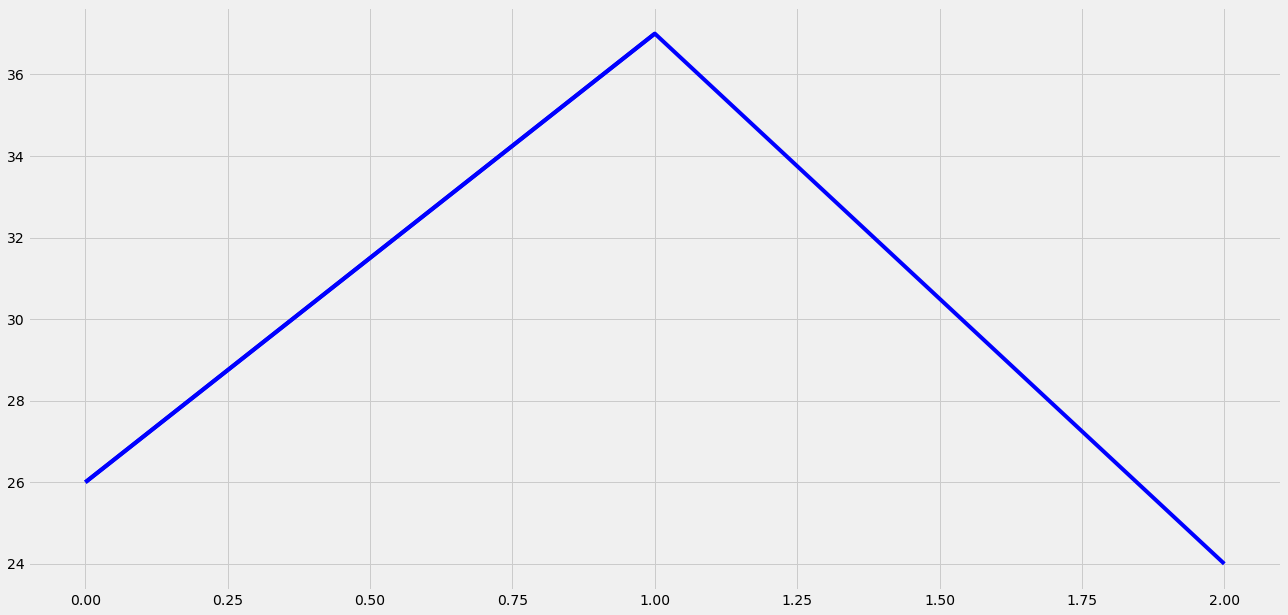

In [139]:
import sys
import gym
import pylab
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

EPISODES = 1000


# A2C(Advantage Actor-Critic) agent for the Cartpole
class A2CAgent:
    def __init__(self, state_size, action_size):
        # if you want to see Cartpole learning, then change to True
        self.render = False
        self.load_model = False
        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1

        # These are hyper parameters for the Policy Gradient
        self.discount_factor = 0.99
        self.actor_lr = 0.001
        self.critic_lr = 0.005

        # create model for policy network
        self.actor = self.build_actor()
        self.critic = self.build_critic()

        if self.load_model:
            self.actor.load_weights("./save_model/cartpole_actor.h5")
            self.critic.load_weights("./save_model/cartpole_critic.h5")

    # approximate policy and value using Neural Network
    # actor: state is input and probability of each action is output of model
    def build_actor(self):
        actor = Sequential()
        actor.add(Dense(24, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        actor.add(Dense(self.action_size, activation='softmax',
                        kernel_initializer='he_uniform'))
        actor.summary()
        # See note regarding crossentropy in cartpole_reinforce.py
        actor.compile(loss='categorical_crossentropy',
                      optimizer=Adam(lr=self.actor_lr))
        return actor

    # critic: state is input and value of state is output of model
    def build_critic(self):
        critic = Sequential()
        critic.add(Dense(24, input_dim=self.state_size, activation='relu',
                         kernel_initializer='he_uniform'))
        critic.add(Dense(self.value_size, activation='linear',
                         kernel_initializer='he_uniform'))
        critic.summary()
        critic.compile(loss="mse", optimizer=Adam(lr=self.critic_lr))
        return critic

    # using the output of policy network, pick action stochastically
    def get_action(self, state):
        policy = self.actor.predict(state, batch_size=1).flatten()
        print(policy)
        return np.random.choice(self.action_size, 1, p=policy)[0]

    # update policy network every episode
    def train_model(self, state, action, reward, next_state, done):
        target = np.zeros((1, self.value_size))
        advantages = np.zeros((1, self.action_size))

        value = self.critic.predict(state)[0]
        next_value = self.critic.predict(next_state)[0]

        if done:
            advantages[0][action] = reward - value
            target[0][0] = reward
        else:
            advantages[0][action] = reward + self.discount_factor * (next_value) - value
            target[0][0] = reward + self.discount_factor * next_value

        self.actor.fit(state, advantages, epochs=1, verbose=0)
        self.critic.fit(state, target, epochs=1, verbose=0)


if __name__ == "__main__":
    # In case of CartPole-v1, maximum length of episode is 500
    env = gym.make('CartPole-v1')
    # get size of state and action from environment
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    print(state_size, action_size)

    # make A2C agent
    agent = A2CAgent(state_size, action_size)

    scores, episodes = [], []

    for e in range(EPISODES):
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        while not done:
            if agent.render:
                env.render()

            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            # if an action make the episode end, then gives penalty of -100
            reward = reward if not done or score == 499 else -100

            agent.train_model(state, action, reward, next_state, done)

            score += reward
            state = next_state

            if done:
                # every episode, plot the play time
                score = score if score == 500.0 else score + 100
                scores.append(score)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                print("episode:", e, "  score:", score)

                # if the mean of scores of last 10 episode is bigger than 490
                # stop training
                if np.mean(scores[-min(10, len(scores)):]) > 490:
                    sys.exit()

In [140]:
a = np.zeros((10,10))
b = np.ones((10,10))

a = a.flatten()
b = b.flatten()
a, b

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

In [142]:
np.concatenate([[a],[b]],axis=1)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.]])